<a href="https://colab.research.google.com/github/ibenatar-96/Bayesian-Modelling-RL/blob/main/Bayesian_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
%cd /content/
!pip install numpyro
!git clone https://github.com/ibenatar-96/Bayesian-Modelling-RL
%cd /content/Bayesian-Modelling-RL
!git pull
%cd /content/

/content
fatal: destination path 'Bayesian-Modelling-RL' already exists and is not an empty directory.
/content/Bayesian-Modelling-RL
Already up to date.
/content


In [25]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import jax
import sys
import os
import time
sys.path.append('/content/Bayesian-Modelling-RL')
import actions
import environment
import utils
import solver
import actions

numpyro.set_host_device_count(4)

In [26]:
def init_env(log_file):
    """
    Inits runtime env, opens new observations log file, and resets utils.INIT_MODEL_PARAMETERS,
    which is a dictionary that holds initial user belief about action probabilities
    for example, utils.INIT_MODEL_PARAMETERS = {
        ('ai_mark', 5): 0.8,
        ('ai_mark', 1): 1.0),
        ...
    }
    For every action in actions_module that does not appear in the INIT_MODEL_PARAMETERS, it sets a new entry in the dict with value 1.0
    """
    open(log_file, 'w').close()
    for (fn_action, action_param) in actions.Actions().get_actions():
        if fn_action not in utils.IGNORE_ACTIONS and (fn_action, action_param) not in utils.INIT_MODEL_PARAMETERS:
            utils.INIT_MODEL_PARAMETERS[(fn_action, action_param)] = 1.0

In [27]:
log_file = "observations.log"
init_env(log_file)
model_parameters = utils.INIT_MODEL_PARAMETERS
slvr = solver.Solver(model_parameters, environment, log_file)
slvr.run()

Agent Q-Learning: 100%|██████████| 50/50 [00:01<00:00, 44.82it/s]


Total Time: 0:00:01.119151
Agent Playing REAL PARAMETERS Tic-Tac-Toe

	Testing 12 Tic-Tac-Toe Games


Agent Playing Tic-Tac-Toe..: 100%|██████████| 12/12 [00:00<00:00, 89.48it/s]

	Total Games Won: 2/12



	Playing Real & Collecting Logs 15 Tic-Tac-Toe Games


Playing Real Tic-Tac-Toe & Collecting Logs..: 100%|██████████| 15/15 [00:00<00:00, 87.70it/s]

	Total Games Won: 3/15


In [28]:
model_beta_parameters = {}
fn_numeric_mapping = {}
posterior_model_parameters = {}

# Parsing Observation file
As defined in the description.

Initialization:
\
$ \quad 1. fn\_numeric\_mapping = \{'ai\_mark:\;0\} $
\
$ \quad 2. model\_beta\_parameters = \{(0,1):\; \{\alpha:\;1,\;\beta:1\},\;(0,2):\;\{\alpha:\;1,\;\beta:1\},\;...,\; (0,9):\; \{\alpha:\;1,\;\beta:1\}\} $

\
Returns:
\
$\quad obs\;list = [(state,\;(function\;num, action\;parameter),\;next\;state),\;...]$

In [29]:
def parse_obs(obs_file):
    """
    Parses the Observation File, returns a List of tuples,
    where each tuple is composed of (State, (Function, Action Parameter), Next State)
    for example:
    State: [-1, 1, 0, -1, 0, -1, 1, 0, 0] where -1 indicates 'X' on the Board, 1 indicates 'O', and 0 indicates None (empty cell)
    (Function, Action Parameter): (0, 5) -> 0 is the number assigned for the function 'ai_mark', mapping is located in fn_numeric_mapping
    Next State: [-1, 1, 0, -1, 1, -1, 1, 0, 0].

    0 is mapped to 'ai_mark' function in global fn_numeric_mapping variable. This mapping exists because NumPyro
    MCMC expects numeric values when running inference.

    fn_numeric_mapping = {
        'ai_mark': 0,
        ...
    }

    This Function also adds initial 'alpha' and 'beta' parameters to the global model_beta_parameters for every NEW
    fn_action and action_param it encounters.
    for example - model_beta_parameters = {
    (0, 5): {'alpha': 1, 'beta': 1},
    (0, 1): {'alpha': 1, 'beta': 1} ... }
    """

    #Converts states from: [['X', 'O', None], ['X', None, 'X'], ['O', None, None]] to [-1, 1, 0, -1, 0, -1, 1, 0, 0]
    #Meaning, creating a minimal state representation, where 'X' is marked a -1, 'O' as 1, and None as 0.
    def minimal_state(state):
        minimal_repr = []
        for i in range(len(state)):
            for j in range(len(state[i])):
                if state[i][j] == 'X':
                    minimal_repr.append(-1)
                elif state[i][j] == 'O':
                    minimal_repr.append(1)
                else:
                    minimal_repr.append(0)
        return minimal_repr

    obs_list = []
    fn_numeric_count = 0
    global model_beta_parameters, fn_numeric_mapping
    with open(obs_file, "r") as obs_log:
        for episode in obs_log:
            episode = episode.strip()  # Remove leading/trailing whitespaces and newlines
            episode_list = eval(episode)  # Convert the line string to a list
            for (state, (fn_name, action_param), next_state) in episode_list:
                if fn_name in utils.IGNORE_ACTIONS:
                    continue
                if fn_name in fn_numeric_mapping.keys():
                    fn_numeric = fn_numeric_mapping[fn_name]
                else:
                    fn_numeric = fn_numeric_count
                    fn_numeric_mapping[fn_name] = fn_numeric_count
                    fn_numeric_count += 1
                obs_list.append((minimal_state(state), (fn_numeric, action_param), minimal_state(next_state)))
                if not (fn_numeric, action_param) in model_beta_parameters:
                    model_beta_parameters[(fn_numeric, action_param)] = {'alpha': 1, 'beta': 1}
    model_beta_parameters = dict(sorted(model_beta_parameters.items()))
    return obs_list

In [30]:
obs_list = parse_obs(log_file)

# AI Model
$ p_i \sim Beta(\alpha, \beta)\;\;\;1 \le i \le number\;of\;functions\;and\;action\;parameters $

$ o_i \sim Bernoulli(p_i)\;\;\;1 \le i \le number\;of\;observations $

In [31]:
def ai_model(obs=None):
    """
    (Tic-Tac-Toe) AI Agent model with NumPyro.
    p is a dictionary mapping (function, action parameter) -> sample from Beta distribution using (alpha, beta).
    obs = [
    ([-1,1,0,...], (0,3), [-1,1,1,...]),
    ([-1,1,...,0], (0,9), [-1,1,...,1]),
    ]
    """
    # p ~ Beta(alpha, beta)
    global model_beta_parameters
    p = {}
    for key in model_beta_parameters.keys():
        alpha = model_beta_parameters[key]['alpha']
        beta = model_beta_parameters[key]['beta']
        p[key] = numpyro.sample(f"p{str(key)}", dist.Beta(alpha, beta))
    # if obs is not None:
    #     for i in range(len(obs)):
    #         s, a, snext = obs[i]
    #         p_i = p[a]
    #         success = jax.numpy.array([1 if s != snext else 0])
    #         numpyro.sample(f"success{i}", dist.Bernoulli(p_i), obs=success)
    if obs is not None:
        p_actions = jax.numpy.array([p[action] for _, action, _ in obs])
        success = jax.numpy.array([1 if state != next_state else 0 for state, _, next_state in obs])
        with numpyro.plate("obs", size=len(obs)):
            numpyro.sample("o", dist.Bernoulli(p_actions), obs=success)


Observation List:
i: 0, obs: ([-1, 0, 0, 0, 0, 0, 0, 0, 0], (0, 4), [-1, 0, 0, 1, 0, 0, 0, 0, 0])
i: 1, obs: ([-1, 0, 0, 1, 0, -1, 0, 0, 0], (0, 5), [-1, 0, 0, 1, 0, -1, 0, 0, 0])
i: 2, obs: ([-1, 0, 0, 1, -1, -1, 0, 0, 0], (0, 2), [-1, 1, 0, 1, -1, -1, 0, 0, 0])
i: 3, obs: ([-1, 1, -1, 1, -1, -1, 0, 0, 0], (0, 7), [-1, 1, -1, 1, -1, -1, 1, 0, 0])
i: 4, obs: ([0, 0, 0, 0, 0, 0, 0, 0, -1], (0, 4), [0, 0, 0, 1, 0, 0, 0, 0, -1])
i: 5, obs: ([0, 0, 0, 1, 0, -1, 0, 0, -1], (0, 5), [0, 0, 0, 1, 0, -1, 0, 0, -1])
i: 6, obs: ([0, 0, 0, 1, 0, -1, 0, -1, -1], (0, 1), [1, 0, 0, 1, 0, -1, 0, -1, -1])
i: 7, obs: ([1, 0, 0, 1, -1, -1, 0, -1, -1], (0, 7), [1, 0, 0, 1, -1, -1, 1, -1, -1])
i: 8, obs: ([0, 0, -1, 0, 0, 0, 0, 0, 0], (0, 1), [1, 0, -1, 0, 0, 0, 0, 0, 0])
i: 9, obs: ([1, 0, -1, 0, 0, 0, 0, -1, 0], (0, 2), [1, 1, -1, 0, 0, 0, 0, -1, 0])
i: 10, obs: ([1, 1, -1, -1, 0, 0, 0, -1, 0], (0, 9), [1, 1, -1, -1, 0, 0, 0, -1, 1])
i: 11, obs: ([1, 1, -1, -1, 0, -1, 0, -1, 1], (0, 7), [1, 1, -1, -1, 0,

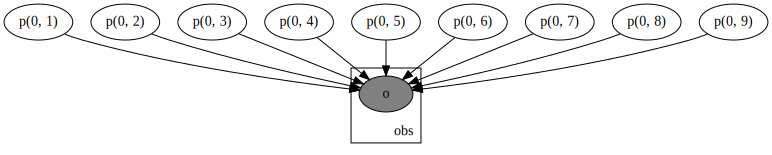

In [32]:
print("Observation List:")
for i, elem in enumerate(obs_list):
    print(f"i: {i}, obs: {elem}")
numpyro.render_model(ai_model, model_args=(obs_list,))

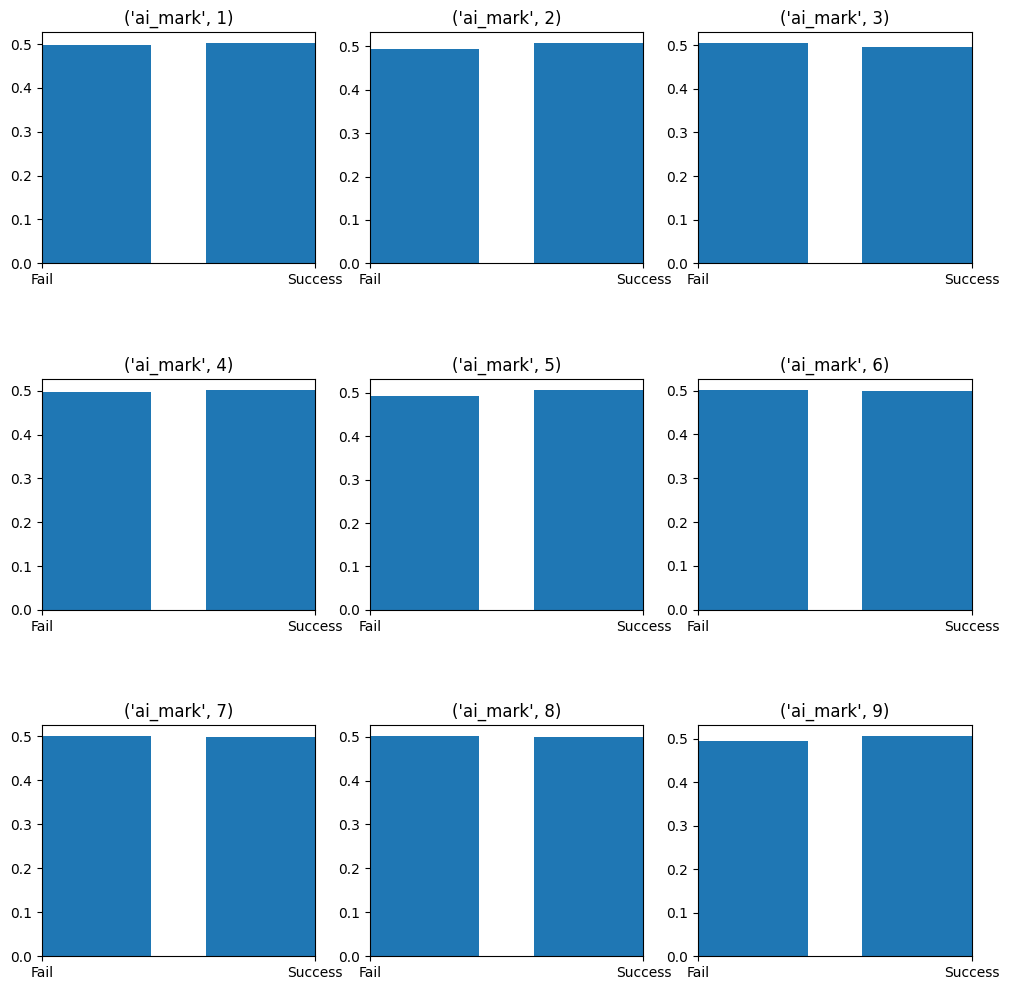

In [33]:
"""
Evaluates Prior Predictive from the Prior Dist.
Expecting to see mass in the bar where observation and imaginations are aligned.
"""
prior_predi = numpyro.infer.Predictive(ai_model, num_samples=10000)
prior_samples = prior_predi(jax.random.PRNGKey(int(time.time() * 1E6)))

num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("prior predictive")
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        o_key = f"p{str((fn_num, action_param))}" # Need to revert this to o{str(key)}
        x_titles = ["Fail", "Success"]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        axs[i, j].set_title(title)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(prior_samples[o_key] > 0.5, axis=0)
        fail_counts = np.sum(prior_samples[o_key] < 0.5, axis=0)
        normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)
plt.show()

In [34]:
"""
Runs Inference using MCMC.
"""
nuts_kernel = numpyro.infer.NUTS(ai_model)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_chains=4,
    num_samples=5000)
mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), obs=obs_list)
mcmc.print_summary()

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   p(0, 1)      0.86      0.12      0.89      0.68      1.00  29539.71      1.00
   p(0, 2)      0.86      0.12      0.89      0.68      1.00  25153.45      1.00
   p(0, 3)      0.83      0.14      0.87      0.63      1.00  28515.11      1.00
   p(0, 4)      0.92      0.07      0.94      0.82      1.00  29853.54      1.00
   p(0, 5)      0.50      0.17      0.50      0.23      0.78  24787.28      1.00
   p(0, 6)      0.88      0.11      0.91      0.72      1.00  32382.25      1.00
   p(0, 7)      0.88      0.11      0.91      0.72      1.00  26468.38      1.00
   p(0, 8)      0.88      0.11      0.91      0.72      1.00  27019.55      1.00
   p(0, 9)      0.83      0.14      0.87      0.63      1.00  27483.34      1.00

Number of divergences: 0


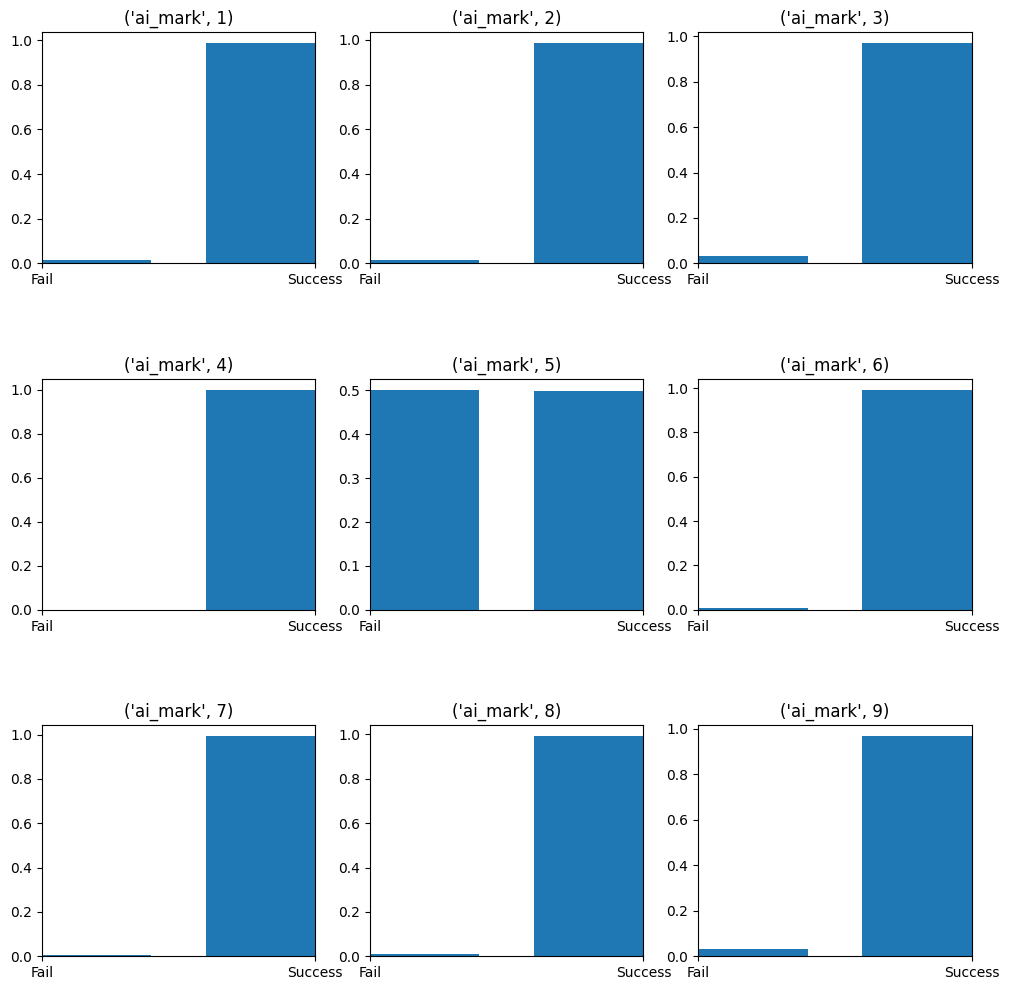

In [35]:
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("posterior")
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        p_key = f"p{str((fn_num, action_param))}"
        x_titles = ["Fail", "Success"]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        axs[i, j].set_title(title)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(mcmc.get_samples()[p_key] > 0.5, axis=0)
        fail_counts = np.sum(mcmc.get_samples()[p_key] < 0.5, axis=0)
        normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)

        # p_key = f"p{str(key)}"
        # axs[i, j].set_title(p_key)
        # axs[i, j].set_xlabel("p")
        # axs[i, j].hist(mcmc.get_samples()[p_key], density=True, bins='auto')
plt.show()


stat	p(0, 1)
-------------
mean	0.857
stddev	0.123
  0%	0.198
  2%	0.547
 25%	0.793
 50%	0.891
 75%	0.953
 98%	0.996
100%	1.000


stat	p(0, 2)
-------------
mean	0.857
stddev	0.124
  0%	0.181
  2%	0.540
 25%	0.793
 50%	0.892
 75%	0.953
 98%	0.996
100%	1.000


stat	p(0, 3)
-------------
mean	0.832
stddev	0.140
  0%	0.059
  2%	0.481
 25%	0.757
 50%	0.870
 75%	0.942
 98%	0.995
100%	1.000


stat	p(0, 4)
-------------
mean	0.923
stddev	0.072
  0%	0.444
  2%	0.733
 25%	0.891
 50%	0.944
 75%	0.977
 98%	0.998
100%	1.000


stat	p(0, 5)
-------------
mean	0.500
stddev	0.167
  0%	0.027
  2%	0.182
 25%	0.380
 50%	0.499
 75%	0.622
 98%	0.816
100%	0.961


stat	p(0, 6)
-------------
mean	0.876
stddev	0.109
  0%	0.253
  2%	0.597
 25%	0.821
 50%	0.906
 75%	0.959
 98%	0.997
100%	1.000


stat	p(0, 7)
-------------
mean	0.875
stddev	0.111
  0%	0.248
  2%	0.588
 25%	0.820
 50%	0.906
 75%	0.961
 98%	0.996
100%	1.000


stat	p(0, 8)
-------------
mean	0.875
stddev	0.112
  0%	0.190
  2%	0.584
 25%	0.822
 50%	0

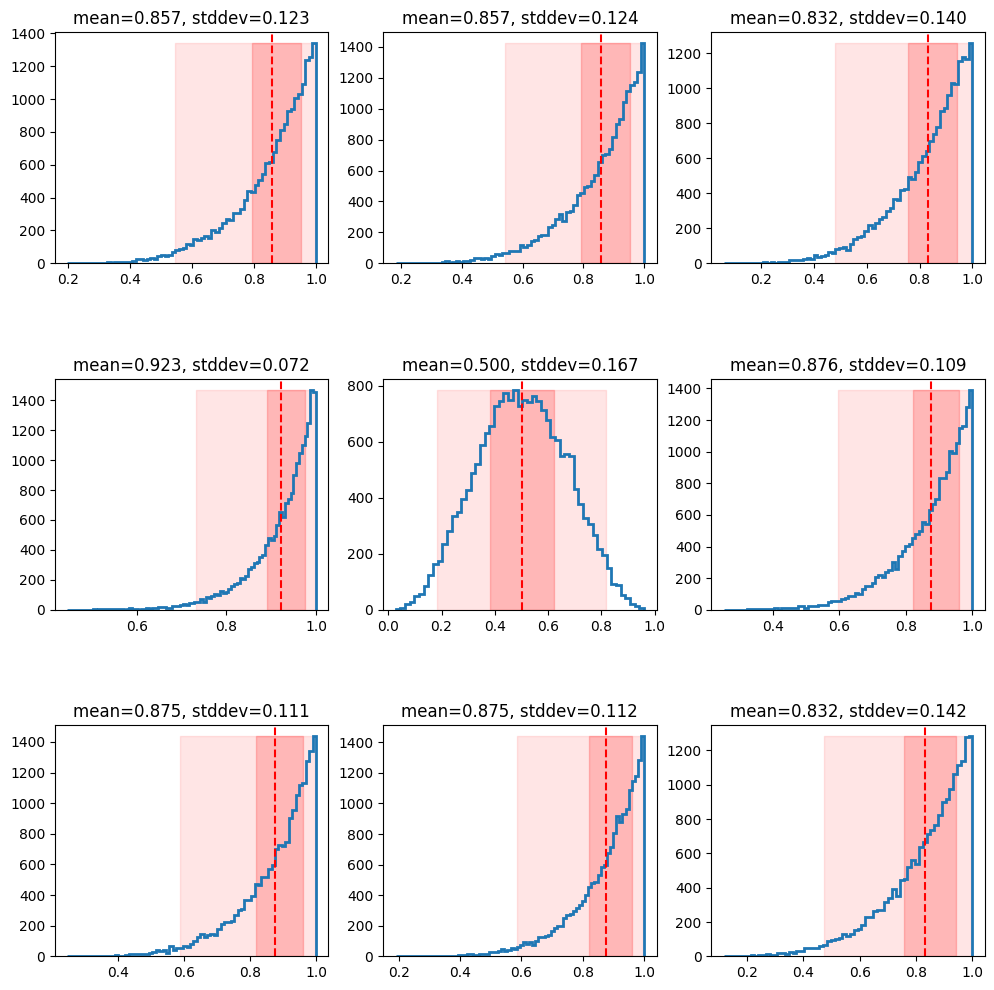

In [36]:
"""
Summarizes Posterior, displays attributes such as mean, standard deviation, quantiles.
"""
distribution_stats = {}
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
# obs_list = list(obs.items())
for i in range(num_rows):
    for j in range(num_cols):
        key = list(model_beta_parameters.keys())[i*3 + j]
        p_key = f"p{str(key)}"
        p = mcmc.get_samples()[p_key]
        p_mean = p.mean()
        p_stddev = p.std()
        distribution_stats[key] = {'mean': p_mean, 'stddev': p_stddev}
        quantiles = [0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]
        pq = np.quantile(p, quantiles)
        print(f"stat\t{p_key}\n-------------")
        print(f"mean\t{p_mean:.3f}")
        print(f"stddev\t{p_stddev:.3f}")
        for q in range(len(quantiles)):
            print(f"{quantiles[q] * 100:3.0f}%\t{pq[q]:.3f}")
        print("\n")
        height, _, _ = axs[i, j].hist(p, histtype="step", lw=2, bins="auto", label="posterior")
        axs[i, j].set_title(f"mean={p_mean:.3f}, stddev={p_stddev:.3f}")
        axs[i, j].axvline(p_mean, ls="dashed", color="red", label="mean")
        axs[i, j].fill_betweenx([0, height.max()], pq[1], pq[-2],
                                color="red", alpha=0.1, label=f"{(quantiles[-2] - quantiles[1]) * 100:.0f}%")
        axs[i, j].fill_betweenx([0, height.max()], pq[2], pq[-3],
                                color="red", alpha=0.2, label=f"{(quantiles[-3] - quantiles[2]) * 100:.0f}%")
plt.show()